# Final prediction models
Use several different models with the selected features and compare their results in terms of R^2 and MSE

Models:
- Random Forest
- XGBoost
- Neural Network
- SVR (?)


## Data Preparation

In [ ]:
# Load data


## Random Forest

## XGBoost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    model=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.35571473768543505                                    
SCORE:                                                                            
0.3299591702567127                                                                
SCORE:                                                                            
0.5526295972182068                                                               
SCORE:                                                                           
0.39160821685627273                                                              
SCORE:                                                                           
0.3465400296014344                                                               
SCORE:                                                                           
0.3945164601011938                                                               
SCORE:                                                           

In [ ]:
best_hyperparams
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

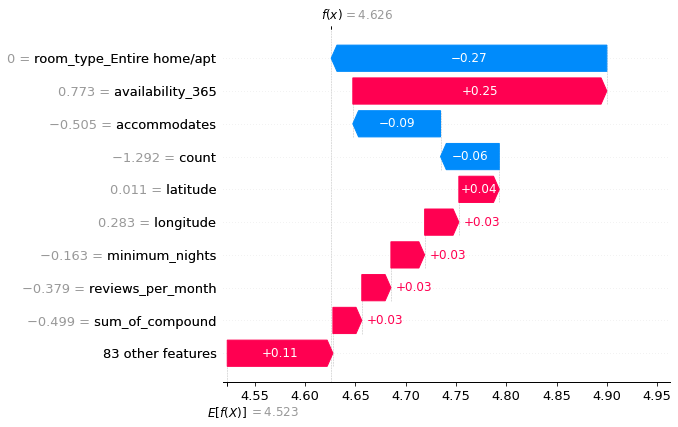

In [ ]:
# train an XGBoost model
model = xgb.XGBRegressor(**best_hyperparams).fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[2])

## Neural Network

Important parts:
- Regularization on the weights (L1 or L2)
- Dropout
- Layers (3 proposed in:
 @article{2021,
   title={Airbnb Price Prediction Using Machine Learning and Sentiment Analysis},
   ISBN={9783030840600},
   ISSN={1611-3349},
   url={http://dx.doi.org/10.1007/978-3-030-84060-0_11},
   DOI={10.1007/978-3-030-84060-0_11},
   journal={Machine Learning and Knowledge Extraction},
   publisher={Springer International Publishing},
   author={Rezazadeh Kalehbasti, Pouya and Nikolenko, Liubov and Rezaei, Hoormazd},
   year={2021},
   pages={173–184})

## Support Vector Regression